## Import essential libraries

In [1]:
import numpy as np
from keras import layers
from keras import regularizers
from keras.models import Model
import h5py
import matplotlib.pyplot as plt
import keras.backend as K
from matplotlib.pyplot import imshow
from keras.utils import to_categorical
%matplotlib inline

/home/vibhutha/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/vibhutha/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


To load dataset we need to write small script

In [2]:
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

From the above output you can see,
`X_train_orig` has `(m, n_h, n_w, n_c)` shape.
`Y_train_orig` has `(1, m)` shape.

For we need to reshape `Y_train_orig` and `Y_test_orig`. But before we need to normalize image vectors

In [4]:
## Normalizing image vector
X_train = X_train_orig / 255
X_test = X_test_orig / 255

## Reshaping Y_train_orig, Y_test_orig and One-Hot Encoding
Y_train = to_categorical(Y_train_orig)
Y_test = to_categorical(Y_test_orig)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1080, 64, 64, 3), (1080, 6), (120, 64, 64, 3), (120, 6))

Let's see one of image from SIGNS database

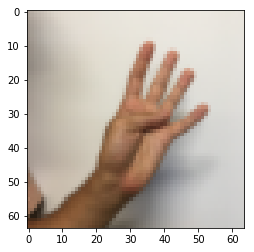

In [5]:
imshow(X_train[5,:,:,:])

## Let's Build the model

The model architecture is as follows.

`X` -> `Conv2D` 32 (7,7) filters with Stride 1 -> `BatchNormalization` -> `Relu` -> `Max Pooling` (2,2) -> `Fully connected` -> `Y_pred`

In [6]:
def sign_model(Input_Batch):
    """
    Creates a Keras model
    Arguments: Training Batch
    
    Return : Keras model instance
    """
    
    X_train = layers.Input(Input_Batch)
    
#     X = layers.ZeroPadding2D((3,3))(X_train)
    
    X = layers.Conv2D(8, kernel_size=(4, 4), strides=1, padding='same', name='conv0',  kernel_regularizer=regularizers.l2(0.01))(X_train)
    X = layers.BatchNormalization(axis = -1, name='bn0')(X)
    X = layers.Activation('relu')(X)
    
    X = layers.MaxPooling2D(pool_size=(8,8), strides=8, padding='same', name='max_pool0')(X)
    
    X = layers.Conv2D(16, kernel_size=(2, 2), strides=(1,1), padding='same', name='conv1',  kernel_regularizer=regularizers.l2(0.01))(X)
    X = layers.BatchNormalization(axis = -1, name='bn1')(X)
    X = layers.Activation('relu')(X)
    
    X = layers.MaxPooling2D(pool_size=(4,4), strides=4, padding='same', name='max_pool1')(X)
    
    X = layers.Flatten()(X)
    X = layers.Dense(6, activation='softmax')(X)
    
    model = Model(inputs=X_train, outputs=X, name='sign_model')

    return model

In [7]:
signmodel = sign_model(X_train.shape[1:])

In [8]:
signmodel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
signmodel.fit(X_train, Y_train, epochs=40, batch_size=64)

Epoch 1/40
1080/1080 [==============================] - 4s 4ms/step - loss: 0.4154 - acc: 0.9333
Epoch 2/40
1080/1080 [==============================] - 4s 4ms/step - loss: 0.4137 - acc: 0.9278
Epoch 3/40
1080/1080 [==============================] - 4s 4ms/step - loss: 0.4015 - acc: 0.9380
Epoch 4/40
1080/1080 [==============================] - 4s 4ms/step - loss: 0.3879 - acc: 0.9389
Epoch 5/40
1080/1080 [==============================] - 4s 4ms/step - loss: 0.3701 - acc: 0.9481
Epoch 6/40
1080/1080 [==============================] - 4s 4ms/step - loss: 0.3653 - acc: 0.9435
Epoch 7/40
1080/1080 [==============================] - 5s 4ms/step - loss: 0.3493 - acc: 0.9583
Epoch 8/40
1080/1080 [==============================] - 5s 4ms/step - loss: 0.3517 - acc: 0.9546
Epoch 9/40
1080/1080 [==============================] - 5s 4ms/step - loss: 0.3527 - acc: 0.9519
Epoch 10/40
1080/1080 [==============================] - 4s 4ms/step - loss: 0.3327 - acc: 0.9537
Epoch 11/40
1080/1080 [======

In [14]:
predicts = signmodel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)

print("Loss :", predicts[0])
print("Test Accuracy:", predicts[1])

120/120 [==============================] - 0s 3ms/step
Loss : 0.34425833423932395
Test Accuracy: 0.9083333373069763


In [15]:
signmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 8)         392       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 8)         0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 8, 8, 8)           0         
_________________________________________________________________
conv1 (Conv2D)               (None, 8, 8, 16)          528       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 8, 8, 16)          64        
__________